In [38]:
import numpy as np
import pickle
from pandas import DataFrame, read_csv
from sklearn import preprocessing
from sklearn import metrics as met
import warnings
import tensorflow as tf
from tensorflow.contrib import rnn
import helperModule as hm
import matplotlib.pyplot as plt
from tensorflow import nn
from matplotlib import gridspec

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'



In [39]:
#########################
############ Hyperparamter
#########################

st_dev = 0.2
learning_rate = 0.001
training_iters = 25000000
batch_size = 128
display_step = 1000
display_testing_step = 4000
keep_rate = 1

n_input = 41 # Number of features
n_steps = 1 # timesteps
n_hidden = 128 # hidden layer num of nodes
n_classes = 5 # KDD99 total classes ( Normal + 4 attack types)


In [40]:
#########################
############ Read in data
#########################

data = pickle.load( open( "kdd99.p", "rb" ) )

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']


In [41]:
num_layers = 2

def RNN(x, W, b, n):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)

    # Define a lstm cell with tensorflow
    #with tf.variable_scope('lstm_cell_def'):

        #lstm_cell = tf.contrib.rnn.LSTMCell(n_hidden, state_is_tuple = True)
        #lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, input_keep_prob=keep_prob)  
    stacked_rnn = []
    for i in range(num_layers):
        stacked_rnn.append(tf.contrib.rnn.DropoutWrapper(tf.nn.rnn_cell.LSTMCell(n, state_is_tuple=True), input_keep_prob=keep_prob)) 
    

    lstm_cell = tf.contrib.rnn.MultiRNNCell(stacked_rnn)
        #lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, input_keep_prob=keep_prob)
                
        
    output, states = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(output[-1], W['out']) + b['out']





In [59]:
# Launch the graph

#learning_rates = [1./10**i for i in range(1,7)]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
#n_hidden = [2**i for i in range(4,10)]
#keep_rates = [0.9 + 0.05 * i for i in range(10)]
keep_rates = [1]
#training_iters = [i for i in range(5000000, 25000000, 1000000)]
training_iters = 5000000



results = {}
loss_plots = {}

for l in learning_rates:
    
    results[l] = []
    loss_plots[l] = {}
    
    for k in keep_rates:
        loss_plots[l][k] = {}
        loss_plots[l][k]['train'] = []
        loss_plots[l][k]['valid'] = []
    
        tf.reset_default_graph()
        
        tf.set_random_seed(0.5)
        
        x = tf.placeholder("float", [None, n_steps, n_input])
        y = tf.placeholder("float", [None, n_classes])
        keep_prob = tf.placeholder(tf.float32, name='keep_prob')

        # Define weights
        W = {
            'out': tf.Variable(tf.truncated_normal([n_hidden, n_classes], stddev=st_dev, seed=0.5))
        }

        b = {
        'out': tf.Variable(tf.zeros([n_classes]))
        }
         
        pred = RNN(x, W, b, n=128)

        # Define loss and optimizer
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
        optimizer = tf.train.AdamOptimizer(learning_rate=l).minimize(cost)

        # Evaluate model
        correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            sess.run(init)
            step = 1
            losses = {'train':[], 'validation':[]}
            # Keep training until reach max iterations
            while step * batch_size < training_iters:
                offset = (step * batch_size) % (y_train.shape[0] - batch_size)
                offset_val = (step * batch_size) % (y_test.shape[0] - batch_size)

                # Generate minibatches for training and validating.
                batch_x = x_train[offset:(offset + batch_size), :]
                batch_y = y_train[offset:(offset + batch_size), :]
                batch_val_x = x_test[offset_val:(offset_val + batch_size), :]
                batch_val_y = y_test[offset_val:(offset_val + batch_size), :]

                # Reshape data to feed into RNN
                batch_x = batch_x.reshape((batch_size, n_steps, n_input))
                batch_val_x = batch_val_x.reshape((batch_size, n_steps, n_input))

                # Run optimization op (backprop)
                sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob:k})
                loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y, keep_prob:k})
                loss_test = sess.run(cost, feed_dict={x: batch_val_x, y: batch_val_y, keep_prob:k})

                if step % display_step == 0:

                    print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) +  ", Minibatch Val Loss= " + \
                          "{:.6f}".format(loss_test)

                #losses['train'].append(loss)
                #losses['validation'].append(loss_test)
                loss_plots[l][k]['train'].append(loss)
                loss_plots[l][k]['valid'].append(loss_test)
                
                step += 1

            print("Optimization Finished for learning rate %6f" % l + " and %d keep_rate" % k)

            y_pred = sess.run(tf.argmax(pred, 1), feed_dict={x:x_test.reshape((-1, n_steps, n_input)), keep_prob:1.0})
            y_true = np.argmax(y_test,1)
            conf_matrix = met.confusion_matrix(y_true, y_pred)
            conf_bench = hm.getBenchmarkResults()
            metrics = hm.computePerformanceMetrics(conf_bench, conf_matrix)
    
            results[l].append(metrics)

dump = pickle.dump(results, open( "tuning_results_dropout.p", "wb" ) )

print 'Finished optimization for all parameters!'

Iter 128000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.705564
Iter 256000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 384000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 512000, Minibatch Loss= 0.000000, Minibatch Val Loss= 54.234493
Iter 640000, Minibatch Loss= 0.000090, Minibatch Val Loss= 27.482365
Iter 768000, Minibatch Loss= 0.000000, Minibatch Val Loss= 33.956680
Iter 896000, Minibatch Loss= 0.000003, Minibatch Val Loss= 0.000003
Iter 1024000, Minibatch Loss= 0.000080, Minibatch Val Loss= 1.327099
Iter 1152000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 1280000, Minibatch Loss= 0.000000, Minibatch Val Loss= 34.567333
Iter 1408000, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.106203
Iter 1536000, Minibatch Loss= 10.578544, Minibatch Val Loss= 10.205993
Iter 1664000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.823039
Iter 1792000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 1920000, Minibatch Loss= 0.000

Optimization Finished for learning rate 0.001000 and 1 keep_rate
Iter 128000, Minibatch Loss= 0.040766, Minibatch Val Loss= 0.786842
Iter 256000, Minibatch Loss= 0.003221, Minibatch Val Loss= 0.003220
Iter 384000, Minibatch Loss= 0.002012, Minibatch Val Loss= 0.006038
Iter 512000, Minibatch Loss= 0.001628, Minibatch Val Loss= 0.411409
Iter 640000, Minibatch Loss= 0.104834, Minibatch Val Loss= 0.012613
Iter 768000, Minibatch Loss= 0.001068, Minibatch Val Loss= 0.046382
Iter 896000, Minibatch Loss= 0.000461, Minibatch Val Loss= 0.000247
Iter 1024000, Minibatch Loss= 0.014521, Minibatch Val Loss= 1.225539
Iter 1152000, Minibatch Loss= 0.002428, Minibatch Val Loss= 0.006843
Iter 1280000, Minibatch Loss= 0.000574, Minibatch Val Loss= 0.607192
Iter 1408000, Minibatch Loss= 0.000084, Minibatch Val Loss= 0.405937
Iter 1536000, Minibatch Loss= 0.000094, Minibatch Val Loss= 0.567223
Iter 1664000, Minibatch Loss= 0.000658, Minibatch Val Loss= 0.555075
Iter 1792000, Minibatch Loss= 0.000313, Minib

In [53]:
acc = {}
tpr_u2r = {}
tpr_r2l = {}
tpr_dos = {}
tpr_probe = {}
tpr_normal = {}

for key in results.keys():
    print key
    acc[key] = []
    tpr_u2r[key] = []
    tpr_r2l[key] = []
    tpr_dos[key] = []
    tpr_probe[key] = []
    tpr_normal[key] = []
    for entry in results[key]:
        acc[key].append(entry['accuracy_model'])
        tpr_u2r[key].append(entry['tpr_model'][3])
        tpr_r2l[key].append(entry['tpr_model'][4])
        tpr_probe[key].append(entry['tpr_model'][1])
        tpr_normal[key].append(entry['tpr_model'][0])
        tpr_dos[key].append(entry['tpr_model'][2])
        print entry['accuracy_model']


0.001
0.90918210199
0.909445743001


In [66]:
for key in loss_plots.keys():
    dic = loss_plots[key]
    for sub_key in dic.keys():
        sub_dic = dic[sub_key]
        print sub_dic['valid']

[1.5903028, 1.5721296, 1.5534573, 1.5294299, 1.5080702, 1.6049442, 1.6806459, 1.6935852, 1.7079233, 1.7240835, 1.742178, 1.7622445, 1.7858841, 1.8127059, 1.8432035, 1.8783367, 1.9189416, 1.9656608, 2.022089, 2.0871193, 2.1642933, 2.253474, 2.3581483, 2.4813781, 2.6242366, 2.7867494, 2.974896, 3.1880887, 3.4223802, 3.6793649, 3.9542065, 4.251874, 4.5636573, 4.885931, 5.2105551, 5.5361133, 5.8584089, 6.1717081, 6.4786029, 6.7726641, 7.0549235, 7.3237643, 7.5774455, 7.8163075, 8.04039, 8.2480202, 8.4459305, 8.627882, 8.7971191, 8.9545345, 9.1009531, 9.2367659, 9.3642588, 9.4818821, 9.5880661, 9.6908274, 9.7832632, 9.8682957, 9.9263496, 9.7361774, 9.4273691, 6.7670708, 1.4342521, 1.7578984, 1.6921675, 0.99536532, 1.5019138, 4.9601135, 4.4619436, 3.9325271, 3.4515164, 3.0421221, 2.6850359, 2.3803301, 2.1346173, 1.932011, 1.7706442, 1.6392723, 1.5329889, 1.4465396, 1.3754153, 1.3159955, 1.2654487, 1.2215389, 1.1825173, 1.1470283, 1.1140094, 1.0826788, 1.0532713, 1.0281335, 1.0066593, 0.98825

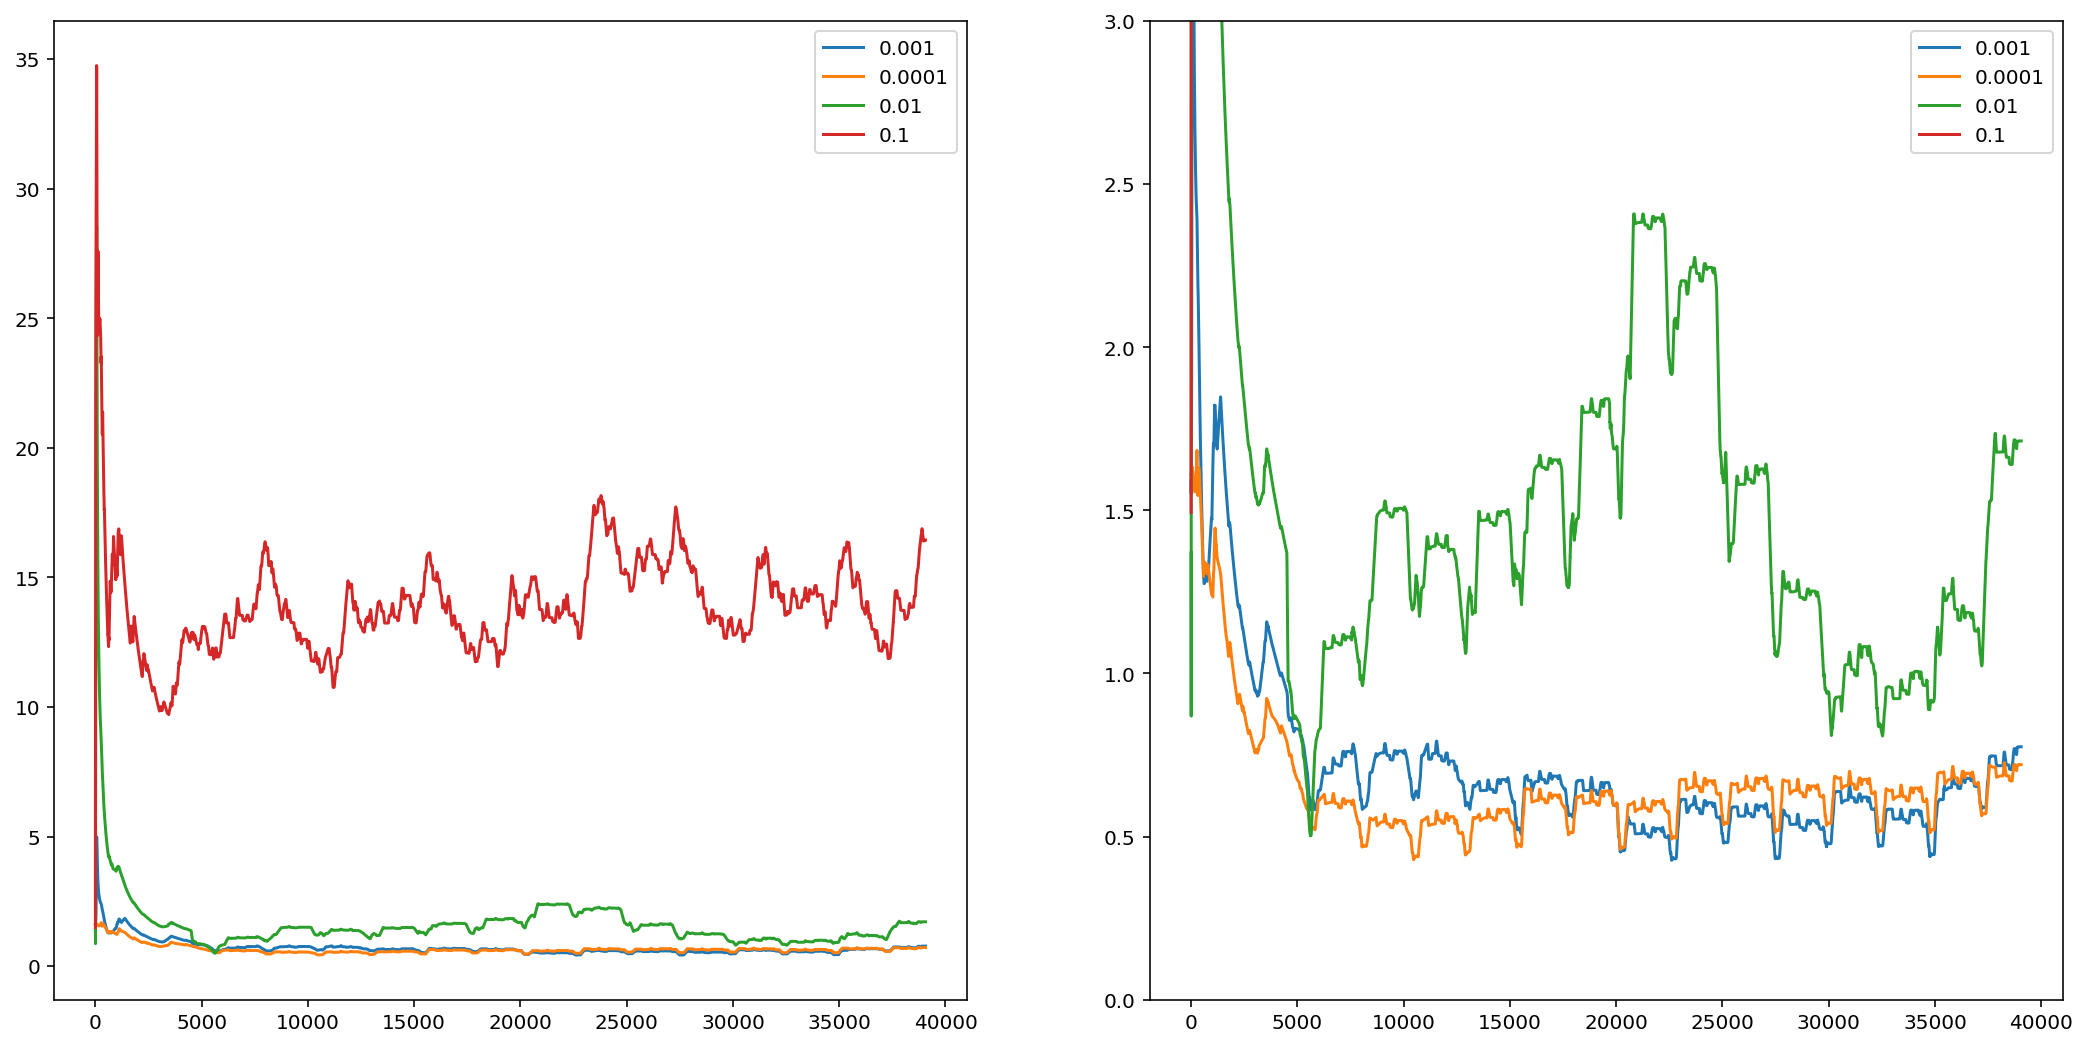

In [89]:

#smoothed_loss = hm.running_mean(losses['train'], 100)
#smoothed_loss_train = hm.running_mean(losses['validation'], 3050)

fig = plt.figure(figsize=(18,9))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:1])
ax2 = plt.subplot(gs[0, 1:2])


#for key in loss_plots[0.001].keys():
#    dic = loss_plots[0.001]
#    ax1.plot(dic[key]['valid'])

    
for key in loss_plots.keys():
    dic = loss_plots[key]
    for sub_key in dic.keys():
        sub_dic = dic[sub_key]
        ax1.plot(hm.running_mean(sub_dic['valid'],4500), label=key)
       
ax1.legend()


for key in loss_plots.keys():
    dic = loss_plots[key]
    for sub_key in dic.keys():
        sub_dic = dic[sub_key]
        ax2.plot(hm.running_mean(sub_dic['valid'],4500), label=key)
       
ax2.set_ylim(0,3)
ax2.legend()

plt.show()






In [56]:
#for key in acc.keys():
#    y = acc[key]
#    x = np.arange(6)

#    plt.plot(x, y)

#plt.ylim([0.91,0.94])
#plt.xticks(x, np.arange(0.001,0.01,0.0015))
#plt.show()